In [1]:
import seaborn as sns
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
from networkx.algorithms import bipartite
from sklearn import model_selection as cv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random
from tqdm import tqdm
from math import sqrt
seed=0
random.seed(seed)

In [2]:
df = pd.read_csv('../data/review.csv')

In [4]:
scaler = MinMaxScaler()
df['overall'] = scaler.fit_transform(df[['overall']])
scaler = MinMaxScaler()
df['nltk'] = scaler.fit_transform(df[['nltk']])
df = df[['reviewerID', 'asin', 'overall', 'nltk']]
df.replace(to_replace=0, value=1e-5, inplace=True)
print(df.shape)
df.head(5)

(92325, 4)


,reviewerID,asin,overall,nltk
0,A361M14PU2GUEG,0700099867,0.75000,0.956798
1,A1QJJU33VNC4S7,0700099867,0.75000,0.700935
2,ANW6EGY12V5XS,0700099867,1.00000,0.996300
3,AHT34BRYFBFT1,0700099867,1.00000,0.329966
4,A248LSBZT4P38V,0700099867,0.00001,0.882544


In [5]:
len(set(zip(df.reviewerID.tolist(), df.asin.tolist()))) # the pairs are unique

92325

In [6]:
user2idx = {}
for i, user in enumerate(df.reviewerID.unique()):
    user2idx[user] = i
item2idx = {}
for i, item in enumerate(df.asin.unique()):
    item2idx[item] = i
n_users = len(df.reviewerID.unique())
n_items = len(df.asin.unique())
print(n_users, n_items)

4939 9899


In [7]:
idx2user = {y: x for x, y in user2idx.items()}
idx2item = {y: x for x, y in item2idx.items()}

In [33]:
df['user_id'] = df['reviewerID'].map(user2idx)
df['item_id'] = df['asin'].map(item2idx)
print(df.shape)
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row.user_id, row.item_id] = row.overall
sparsity = float(np.count_nonzero(ratings))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

(92325, 6)
Sparsity: 0.19%


In [9]:
test_df = pd.read_csv('../data/test.csv')
scaler = MinMaxScaler()
test_df['overall'] = scaler.fit_transform(test_df[['overall']])
scaler = MinMaxScaler()
test_df['nltk'] = scaler.fit_transform(test_df[['nltk']])
test_df = test_df[['reviewerID', 'asin', 'overall', 'nltk']]
test_df.replace(to_replace=0, value=1e-5, inplace=True)
test_df['user_id'] = test_df['reviewerID'].map(user2idx)
test_df['item_id'] = test_df['asin'].map(item2idx)
print(test_df.shape)
test_df.head(5)

(19756, 6)


,reviewerID,asin,overall,nltk,user_id,item_id
0,A005481137I9SCAWEF7ON,B0009OGJ02,0.75,0.996199,373,2622
1,A005481137I9SCAWEF7ON,B00008URUA,1.00,0.863530,373,1632
2,A005481137I9SCAWEF7ON,B0007ZNH5I,0.75,0.991299,373,2498
3,A005481137I9SCAWEF7ON,B00004T4XO,1.00,0.991299,373,671
4,A049511737EMTVGTZXNKV,B000Q6J51S,1.00,0.982897,2190,3934


In [10]:
train_df = pd.read_csv('../data/train.csv')
scaler = MinMaxScaler()
train_df['overall'] = scaler.fit_transform(train_df[['overall']])
scaler = MinMaxScaler()
train_df['nltk'] = scaler.fit_transform(train_df[['nltk']])
train_df = train_df[['reviewerID', 'asin', 'overall', 'nltk']]
train_df.replace(to_replace=0, value=1e-5, inplace=True)
train_df['user_id'] = train_df['reviewerID'].map(user2idx)
train_df['item_id'] = train_df['asin'].map(item2idx)
print(train_df.shape)
tmp_test_df = test_df.copy()
tmp_test_df['overall'] = [0] * tmp_test_df.shape[0]
tmp_test_df['nltk'] = [0] * tmp_test_df.shape[0]
train_df = pd.concat([train_df, tmp_test_df])
print(train_df.shape)
train_df.head(5)

(72569, 6)
(92325, 6)


,reviewerID,asin,overall,nltk,user_id,item_id
0,A361M14PU2GUEG,0700099867,0.75000,0.956798,0,0
1,A1QJJU33VNC4S7,0700099867,0.75000,0.700935,1,0
2,ANW6EGY12V5XS,0700099867,1.00000,0.996300,2,0
3,AHT34BRYFBFT1,0700099867,1.00000,0.329966,3,0
4,A248LSBZT4P38V,0700099867,0.00001,0.882544,4,0


In [11]:
# train_df = pd.DataFrame(columns=df.columns)
# test_df = pd.DataFrame(columns=df.columns)
# for user in tqdm(df.reviewerID.unique()):
#     tmp = df[df['reviewerID'] == user]
#     if tmp.shape[0] >= 20:
#         tmp_train_df, tmp_test_df = cv.train_test_split(tmp, test_size=12, random_state=seed)
#         train_df = pd.concat([train_df, tmp_train_df])
#         test_df = pd.concat([test_df, tmp_test_df])
#         tmp_test_df['overall'] = [0] * tmp_test_df.shape[0]
#         train_df = pd.concat([train_df, tmp_test_df])
#     else:
#         train_df = pd.concat([train_df, tmp])
# print(train_df.shape, test_df.shape)

# User-based

## 1. Naive baseline


The prediction of the rating of user $u$ towards an item $i$:
$$
\hat{r_{u,i}}=\mu+d_u+d_i
$$

$\mu$: average rating of items by all users.

$d_u$: difference of user $u$'s average rating from $\mu$.

$d_b$: difference of item $i$'s average rating from $\mu$.

In [12]:
def naive_baseline(score):
    def predict_rating_naive(user, item, rating_df, mu, score):
        d_u = rating_df[rating_df['user_id'] == user][score].mean() - mu
        d_i = rating_df[rating_df['item_id'] == item][score].mean() - mu
        return mu + d_u + d_i
    mu = train_df[score].mean()
    preds = []
    for i in tqdm(range(len(test_df['user_id']))):
        user = test_df['user_id'].tolist()[i]
        item = test_df['item_id'].tolist()[i]
        assert(train_df[(train_df['user_id'] == user) & (train_df['item_id'] == item)][score].tolist() == [0])
        preds.append(predict_rating_naive(user, item, train_df, mu, score))
    print("Naive baseline with {} score".format(score))
    print("    rmse:", sqrt(mean_squared_error(preds, test_df[score].tolist())))
    print("    mae:", mean_absolute_error(preds, test_df[score].tolist()))

In [13]:
naive_baseline('overall')

100%|████████████████████████████████████| 19756/19756 [00:26<00:00, 753.01it/s]

Naive baseline with overall score
    rmse: 0.4110363404068277
    mae: 0.3483667058444958


In [14]:
naive_baseline('nltk')

100%|████████████████████████████████████| 19756/19756 [00:26<00:00, 733.90it/s]

Naive baseline with nltk score
    rmse: 0.4248654439503167
    mae: 0.37322816065982145


## 2. Memory-based

The prediction of the rating of user $u$ towards an item $i$:
$$
\hat{r_{u,i}} = \bar{r_u} + \alpha \sum_{j=1}^n sim(u,j)(r_{j,i}-\bar{r_j}), \quad \bar{r_u}=\frac{1}{I_u}\sum_{j\in I_u}r_{u,j}
$$

$I_u$: the set of items on which user $u$ voted.

$\bar{r_u}$: average rating given by user $u$.

$sim(u,j)$: the similarity measure between user $u$ and user $j$. The weight of the edges in the weighted bipartite graph projection.

$\alpha$: normalizing factor so that the absolute values of the similarity metrics sum to 1.

$r_{j,i}$: actual rating given by user $j$ to item $i$.

$n$: number of users that give a rating to item $i$.

### OMP

Construct the one mode projection (OMP) by summing the edge weights of bipartite graph if two users review the same product. For example, if $u$ and $v$ both review product $i$, $u$ has a sentiment score of 0.8 while $v$ has a sentiment score of 0.6, the edge weight of OMP should be 1.4.

In [15]:
def get_user_avg_rating(user, g):
    user_weights = []
    for e in g.edges(user):
        user_weights.append(g.get_edge_data(*e)['weight'])
    return np.mean(user_weights)

def predict_rating_bipartite(user, item, g, proj_g):
    u_avg_rating = get_user_avg_rating(user, g) # average rating given by user u
    similarity_sum = 0
    count = 0
    pred = u_avg_rating
    for e in proj_g.edges(user):
        j = e[1]
        if (j, item) in g.edges and g.get_edge_data(*(j, item))['weight'] != 0:
            j_avg_rating = get_user_avg_rating(j, g) # average rating given by user j
            similarity_sum += abs(proj_g.get_edge_data(*e)['weight'])
            count += proj_g.get_edge_data(*e)['weight'] * (g.get_edge_data(*(j, item))['weight'] - j_avg_rating)
    if similarity_sum:
        pred += 1 / similarity_sum * count
    return pred

In [16]:
def my_weight(G, u, v, weight="weight"):
    w = 0
    for nbr in set(G[u]) & set(G[v]):
        w += G[u][nbr].get(weight, 1) + G[v][nbr].get(weight, 1)
    return w

def omp(score):
    # train graph
    train_g = nx.Graph()
    train_g.add_nodes_from(train_df['reviewerID'].tolist(), bipartite=0)
    train_g.add_nodes_from(train_df['asin'].tolist(), bipartite=1)
    edges = list(zip(train_df['reviewerID'].tolist(), train_df['asin'].tolist(), train_df[score].tolist()))
    train_g.add_weighted_edges_from(edges)

    train_proj_user_g = bipartite.generic_weighted_projected_graph(
        train_g, list(set(train_df['reviewerID'].tolist())), weight_function=my_weight
    )
#     print(train_proj_user_g.get_edge_data(*list(train_proj_user_g.edges)[0]))
#     print(train_proj_user_g.number_of_nodes())

    preds = []
    for i in tqdm(range(len(test_df['user_id']))):
        user = test_df['user_id'].tolist()[i]
        item = test_df['item_id'].tolist()[i]
        assert(train_df[(train_df['user_id'] == user) & (train_df['item_id'] == item)][score].tolist() == [0])
        preds.append(predict_rating_bipartite(idx2user[user], idx2item[item], train_g, train_proj_user_g))
    print("OMP with {} score".format(score))
    print("    rmse:", sqrt(mean_squared_error(preds, test_df[score].tolist())))
    print("    mae:", mean_absolute_error(preds, test_df[score].tolist()))    

In [17]:
omp('overall')

100%|████████████████████████████████████| 19756/19756 [00:38<00:00, 517.88it/s]

OMP with overall score
    rmse: 0.2887155964432742
    mae: 0.22577948775033482


In [18]:
omp('nltk')

100%|████████████████████████████████████| 19756/19756 [00:36<00:00, 547.04it/s]

OMP with nltk score
    rmse: 0.2753860677767139
    mae: 0.21061472376297682


### Recommendation power

In [20]:
score = 'overall'
def rp_weighted_projected_graph(B, nodes, weight):
    G = nx.DiGraph()
    G.graph.update(B.graph)
    G.add_nodes_from((n, B.nodes[n]) for n in nodes)
    for u in nodes:
        r_u = 0
        unbrs = set(B[u]) # items reviewed by u
        nbrs2 = set()
        for un in unbrs:
            r_u += B[u][un].get(weight, 1)
            for e in B.in_edges(un):
                nbrs2.add(e[0])
        nbrs2 = nbrs2 - set([u]) # set of users that reviewed the same items as u 
        for v in nbrs2:
            vnbrs = set(B[v])
            common = unbrs & vnbrs # items that are reviewed by both u and v
            w = 0
            for b in common:
                r_b = 0
                for e in B.in_edges(b):
                    r_b += B[e[0]][e[1]].get(weight, 1)
                if r_u:
                    w += B[u][b].get(weight, 1)/r_u
                if r_b:
                    w *= B[v][b].get(weight, 1)/r_b
            G.add_edge(u, v, weight=w)
    return G

train_g = nx.DiGraph()
train_g.add_nodes_from(train_df['reviewerID'].tolist(), bipartite=0)
train_g.add_nodes_from(train_df['asin'].tolist(), bipartite=1)
edges = list(zip(train_df['reviewerID'].tolist(), train_df['asin'].tolist(), train_df[score].tolist()))
train_g.add_weighted_edges_from(edges)

train_proj_user_g = rp_weighted_projected_graph(train_g, list(set(train_df['reviewerID'].tolist())), 'weight')

In [21]:
print(train_proj_user_g)

DiGraph with 4939 nodes and 2255108 edges


Test function:

In [22]:
pairs = [('ANW6EGY12V5XS', 'AHT34BRYFBFT1'), ('A22KRTIWDLOA98', 'A1NH2K8N77S5RY')]
def test(pairs):
    rps = []
    for (u, v) in pairs:
        i1 = train_df[train_df['reviewerID'] == u].asin.tolist()
        i2 = train_df[train_df['reviewerID'] == v].asin.tolist()
        common = set(i1) & set(i2)
        rp = 0
        for b in common:
            r_b = np.sum(train_df[train_df['asin'] == b].overall)
            r_u = np.sum(train_df[train_df['reviewerID'] == u].overall)
            r_ub = train_df[(train_df['reviewerID'] == u) & (train_df['asin'] == b)].overall.tolist()[0]
            r_vb = train_df[(train_df['reviewerID'] == v) & (train_df['asin'] == b)].overall.tolist()[0]
            if r_u:
                rp += r_ub / r_u
            if r_b:
                rp *= r_vb / r_b
        rps.append(rp)
    return rps
true_rps = test(pairs)
print(true_rps)
test_rps = []
for p in pairs:
    test_rps.append(train_proj_user_g.get_edge_data(*p).get('weight', 1))
print(test_rps)
print(true_rps == test_rps)

[0.01512280759455262, 0.010561027942869379]
[0.01512280759455262, 0.010561027942869379]
True


In [23]:
def rp(score):
    # train graph
    train_g = nx.DiGraph() # should be directed graph
    train_g.add_nodes_from(train_df['reviewerID'].tolist(), bipartite=0)
    train_g.add_nodes_from(train_df['asin'].tolist(), bipartite=1)
    edges = list(zip(train_df['reviewerID'].tolist(), train_df['asin'].tolist(), train_df[score].tolist()))
    train_g.add_weighted_edges_from(edges)

    train_proj_user_g = rp_weighted_projected_graph(train_g, list(set(train_df['reviewerID'].tolist())), 'weight')
#     print(train_proj_user_g.get_edge_data(*list(train_proj_user_g.edges)[0]))
#     print(train_proj_user_g.number_of_nodes())

    preds = []
    for i in tqdm(range(len(test_df['user_id']))):
        user = test_df['user_id'].tolist()[i]
        item = test_df['item_id'].tolist()[i]
        assert(train_df[(train_df['user_id'] == user) & (train_df['item_id'] == item)][score].tolist() == [0])
        preds.append(predict_rating_bipartite(idx2user[user], idx2item[item], train_g, train_proj_user_g))
    print("RP with {} score".format(score))
    print("    rmse:", sqrt(mean_squared_error(preds, test_df[score].tolist())))
    print("    mae:", mean_absolute_error(preds, test_df[score].tolist()))    

In [24]:
rp('overall')

100%|████████████████████████████████████| 19756/19756 [00:36<00:00, 548.30it/s]

RP with overall score
    rmse: 0.33385977139173995
    mae: 0.2685106869811831


In [25]:
rp('nltk')

100%|████████████████████████████████████| 19756/19756 [00:36<00:00, 542.05it/s]

RP with nltk score
    rmse: 0.3359128621155487
    mae: 0.26733887772204573


### Cosine similarity & Pearson

In [26]:
def predict_rating_sim(user, item, sim_matrix, train_df):
    mean_df = train_df.mean(axis=1)
    u_avg_rating = mean_df[user]
    pred = u_avg_rating
    similarity_sum = 0
    count = 0
    for j in range(len(train_df)):
        if j != user and train_df[j][item] != 0:
            similarity_sum += abs(sim_matrix[j][user])
            count += sim_matrix[j][user] * (train_df[j][item] - mean_df[j])
    if similarity_sum:
        pred += 1 / similarity_sum * count
    return pred

def similarity(score):
    train_data_matrix = np.zeros((n_users, n_items))
    for row in train_df.itertuples():
        if score == 'overall':
            train_data_matrix[row.user_id, row.item_id] = row.overall
        if score == 'nltk':
            train_data_matrix[row.user_id, row.item_id] = row.nltk

    # cosine similarity
    sim_matrix = pairwise_distances(train_data_matrix, metric='cosine')
    # print(sim_matrix.shape)
    preds = []
    for i in tqdm(range(len(test_df['user_id']))):
        user = test_df['user_id'].tolist()[i]
        item = test_df['item_id'].tolist()[i]
        assert(train_df[(train_df['user_id'] == user) & (train_df['item_id'] == item)][score].tolist() == [0])
        preds.append(predict_rating_sim(user, item, sim_matrix, train_data_matrix))
    print("Cosine with {} score".format(score))
    print("    rmse:", sqrt(mean_squared_error(preds, test_df[score].tolist())))
    print("    mae:", mean_absolute_error(preds, test_df[score].tolist()))
    
    # pearson
    pearson_matrix = np.corrcoef(train_data_matrix)
    # print(pearson_matrix.shape)
    preds = []
    for i in tqdm(range(len(test_df['user_id']))):
        user = test_df['user_id'].tolist()[i]
        item = test_df['item_id'].tolist()[i]
        assert(train_df[(train_df['user_id'] == user) & (train_df['item_id'] == item)][score].tolist() == [0])
        preds.append(predict_rating_sim(user, item, pearson_matrix, train_data_matrix))
    print("Pearson with {} score".format(score))
    print("    rmse:", sqrt(mean_squared_error(preds, test_df[score].tolist())))
    print("    mae:", mean_absolute_error(preds, test_df[score].tolist()))

In [27]:
similarity('overall')

100%|█████████████████████████████████████| 19756/19756 [04:50<00:00, 67.94it/s]


Cosine with overall score
    rmse: 0.31522413345912836
    mae: 0.23679130440405566


100%|█████████████████████████████████████| 19756/19756 [04:49<00:00, 68.35it/s]

Pearson with overall score
    rmse: 0.771526795286055
    mae: 0.5360920458900261


In [28]:
similarity('nltk')

100%|█████████████████████████████████████| 19756/19756 [04:49<00:00, 68.32it/s]


Cosine with nltk score
    rmse: 0.28877558833642825
    mae: 0.1931522123931581


100%|█████████████████████████████████████| 19756/19756 [04:52<00:00, 67.60it/s]

Pearson with nltk score
    rmse: 0.8190660842382917
    mae: 0.5548605612740287


## 3. Clustered weighted bipartite projection

### Cluster on user side

In [34]:
def user_cluster(score):
    train_g = nx.Graph()
    train_g.add_nodes_from(train_df['reviewerID'].tolist(), bipartite=0)
    train_g.add_nodes_from(train_df['asin'].tolist(), bipartite=1)
    edges = list(zip(train_df['reviewerID'].tolist(), train_df['asin'].tolist(), train_df[score].tolist()))
    train_g.add_weighted_edges_from(edges)
    
    train_proj_g = bipartite.generic_weighted_projected_graph(
            train_g, list(set(train_df['reviewerID'].tolist())), weight_function=my_weight
        )
    train_sim = nx.to_numpy_array(train_proj_g, weight='weight')
    print(train_sim.shape)

    tran_train_df = train_df.copy()
    tran_test_df = test_df.copy()
    rmse = []
    mae = []
    for k in range(50, 900, 100):
        print("="*25 + str(k) + "="*25)
        sc = SpectralClustering(k, affinity='precomputed', n_init=100, random_state=seed)
        sc.fit(train_sim)
        idx2labels = {}
        for idx, l in enumerate(sc.labels_):
            idx2labels[idx] = str(l)
        tran_train_df['user_clustering_labels'] = tran_train_df['user_id'].map(idx2labels)
        tran_test_df['user_clustering_labels'] = tran_test_df['user_id'].map(idx2labels)

        train_cluster_g = nx.Graph()
        train_cluster_g.add_nodes_from(tran_train_df['user_clustering_labels'].tolist(), bipartite=0)
        train_cluster_g.add_nodes_from(tran_train_df['asin'].tolist(), bipartite=1)
        edges = list(zip(tran_train_df['user_clustering_labels'].tolist(), tran_train_df['asin'].tolist(), \
                         tran_train_df[score].tolist()))
        train_cluster_g.add_weighted_edges_from(edges)
        train_cluster_proj_g = bipartite.generic_weighted_projected_graph(
            train_cluster_g, list(set(tran_train_df['user_clustering_labels'].tolist())), weight_function=my_weight
        )

        preds = []
        for i in tqdm(range(len(tran_test_df['user_clustering_labels']))):
            user = tran_test_df['user_clustering_labels'].tolist()[i]
            item = tran_test_df['item_id'].tolist()[i]
            preds.append(predict_rating_bipartite(user, idx2item[item], train_cluster_g, train_cluster_proj_g))
        rmse.append(sqrt(mean_squared_error(preds, test_df[score].tolist())))
        mae.append(mean_absolute_error(preds, test_df[score].tolist()))
    return rmse, mae

In [35]:
rmse_user_overall, mae_user_overall = user_cluster('overall')

(4939, 4939)
=========================50=========================


100%|████████████████████████████████████| 19756/19756 [02:27<00:00, 134.03it/s]


=========================150=========================


100%|████████████████████████████████████| 19756/19756 [02:22<00:00, 138.47it/s]


=========================250=========================


100%|████████████████████████████████████| 19756/19756 [01:53<00:00, 173.50it/s]


=========================350=========================


100%|████████████████████████████████████| 19756/19756 [02:04<00:00, 159.05it/s]


=========================450=========================


100%|████████████████████████████████████| 19756/19756 [02:02<00:00, 161.17it/s]


=========================550=========================


100%|████████████████████████████████████| 19756/19756 [02:05<00:00, 158.01it/s]


=========================650=========================


100%|████████████████████████████████████| 19756/19756 [02:00<00:00, 164.17it/s]


=========================750=========================


100%|████████████████████████████████████| 19756/19756 [01:47<00:00, 183.54it/s]


=========================850=========================


100%|████████████████████████████████████| 19756/19756 [01:46<00:00, 185.46it/s]


In [36]:
rmse_user_overall

[0.3321779914756571,
 0.3187779258024614,
 0.3527021797463017,
 0.33484701936981576,
 0.35053326331004103,
 0.3535648857010521,
 0.37026410650504255,
 0.38993134656877376,
 0.4050283194125165]

In [37]:
rmse_user_nltk, mae_user_nltk = user_cluster('nltk')

(4939, 4939)
=========================50=========================


100%|████████████████████████████████████| 19756/19756 [02:35<00:00, 126.89it/s]


=========================150=========================


100%|████████████████████████████████████| 19756/19756 [02:16<00:00, 144.81it/s]


=========================250=========================


100%|████████████████████████████████████| 19756/19756 [02:05<00:00, 157.27it/s]


=========================350=========================


100%|████████████████████████████████████| 19756/19756 [02:13<00:00, 148.49it/s]


=========================450=========================


100%|████████████████████████████████████| 19756/19756 [01:53<00:00, 174.56it/s]


=========================550=========================


100%|████████████████████████████████████| 19756/19756 [01:50<00:00, 179.06it/s]


=========================650=========================


100%|████████████████████████████████████| 19756/19756 [01:53<00:00, 173.95it/s]


=========================750=========================


100%|████████████████████████████████████| 19756/19756 [01:41<00:00, 195.45it/s]


=========================850=========================


100%|████████████████████████████████████| 19756/19756 [02:12<00:00, 149.15it/s]


In [38]:
rmse_user_nltk

[0.297981965497826,
 0.2869112115686484,
 0.30885014566606567,
 0.31194539686754763,
 0.33826560100929165,
 0.35599170480431697,
 0.345917072287147,
 0.3715986086005995,
 0.32551076390354156]

### Cluster on item side

In [39]:
def item_cluster(score):
    train_g = nx.Graph()
    train_g.add_nodes_from(train_df['reviewerID'].tolist(), bipartite=0)
    train_g.add_nodes_from(train_df['asin'].tolist(), bipartite=1)
    edges = list(zip(train_df['reviewerID'].tolist(), train_df['asin'].tolist(), train_df[score].tolist()))
    train_g.add_weighted_edges_from(edges)
    
    train_proj_g = bipartite.generic_weighted_projected_graph(
            train_g, list(set(train_df['asin'].tolist())), weight_function=my_weight
        )
    train_sim = nx.to_numpy_array(train_proj_g, weight='weight')
    print(train_sim.shape)

    tran_train_df = train_df.copy()
    tran_test_df = test_df.copy()
    rmse = []
    mae = []
    for k in range(50, 900, 100):
        print("="*25 + str(k) + "="*25)
        sc = SpectralClustering(k, affinity='precomputed', n_init=100, random_state=seed)
        sc.fit(train_sim)
        idx2labels = {}
        for idx, l in enumerate(sc.labels_):
            idx2labels[idx] = str(l)
        tran_train_df['item_clustering_labels'] = tran_train_df['item_id'].map(idx2labels)
        tran_test_df['item_clustering_labels'] = tran_test_df['item_id'].map(idx2labels)

        train_cluster_g = nx.Graph()
        train_cluster_g.add_nodes_from(tran_train_df['reviewerID'].tolist(), bipartite=0)
        train_cluster_g.add_nodes_from(tran_train_df['item_clustering_labels'].tolist(), bipartite=1)
        edges = list(zip(tran_train_df['reviewerID'].tolist(), tran_train_df['item_clustering_labels'].tolist(), \
                         tran_train_df[score].tolist()))
        train_cluster_g.add_weighted_edges_from(edges)
        train_cluster_proj_g = bipartite.generic_weighted_projected_graph(
            train_cluster_g, list(set(tran_train_df['item_clustering_labels'].tolist())), weight_function=my_weight
        )

        preds = []
        for i in tqdm(range(len(tran_test_df['item_clustering_labels']))):
            user = tran_test_df['user_id'].tolist()[i]
            item = tran_test_df['item_clustering_labels'].tolist()[i]
            preds.append(predict_rating_bipartite(idx2user[user], item, train_cluster_g, train_cluster_proj_g))
        rmse.append(sqrt(mean_squared_error(preds, test_df[score].tolist())))
        mae.append(mean_absolute_error(preds, test_df[score].tolist()))
    return rmse, mae

In [40]:
rmse_item_overall, mae_item_overall = item_cluster('overall')

(9899, 9899)
=========================50=========================


100%|███████████████████████████████████| 19756/19756 [00:08<00:00, 2418.58it/s]


=========================150=========================


100%|███████████████████████████████████| 19756/19756 [00:09<00:00, 2034.35it/s]


=========================250=========================


100%|███████████████████████████████████| 19756/19756 [00:11<00:00, 1766.39it/s]


=========================350=========================


100%|███████████████████████████████████| 19756/19756 [00:11<00:00, 1726.55it/s]


=========================450=========================


100%|███████████████████████████████████| 19756/19756 [00:14<00:00, 1384.62it/s]


=========================550=========================


100%|███████████████████████████████████| 19756/19756 [00:13<00:00, 1502.56it/s]


=========================650=========================


100%|███████████████████████████████████| 19756/19756 [00:14<00:00, 1383.17it/s]


=========================750=========================


100%|███████████████████████████████████| 19756/19756 [00:14<00:00, 1331.84it/s]


=========================850=========================


100%|███████████████████████████████████| 19756/19756 [00:12<00:00, 1531.72it/s]


In [41]:
rmse_item_overall

[0.4886168803298372,
 0.4657954940322945,
 0.4643925744963401,
 0.44949454135959055,
 0.45133666110070136,
 0.4617512885495678,
 0.4527374296661184,
 0.4429070328246449,
 0.4384775191584321]

In [43]:
rmse_item_nltk, mae_item_nltk = item_cluster('nltk')

(9899, 9899)
=========================50=========================


100%|███████████████████████████████████| 19756/19756 [00:08<00:00, 2422.75it/s]


=========================150=========================


100%|███████████████████████████████████| 19756/19756 [00:10<00:00, 1949.18it/s]


=========================250=========================


100%|███████████████████████████████████| 19756/19756 [00:11<00:00, 1760.99it/s]


=========================350=========================


100%|███████████████████████████████████| 19756/19756 [00:11<00:00, 1668.90it/s]


=========================450=========================


100%|███████████████████████████████████| 19756/19756 [00:11<00:00, 1786.70it/s]


=========================550=========================


100%|███████████████████████████████████| 19756/19756 [00:13<00:00, 1441.26it/s]


=========================650=========================


100%|███████████████████████████████████| 19756/19756 [00:13<00:00, 1486.23it/s]


=========================750=========================


100%|███████████████████████████████████| 19756/19756 [00:13<00:00, 1430.11it/s]


=========================850=========================


100%|███████████████████████████████████| 19756/19756 [00:16<00:00, 1200.44it/s]


In [44]:
rmse_item_nltk

[0.5055782011822051,
 0.4714811966703853,
 0.4734844595886776,
 0.45717799249600266,
 0.4618551381798642,
 0.44501880335009714,
 0.45133328532435296,
 0.45392105090282664,
 0.45294173450817465]

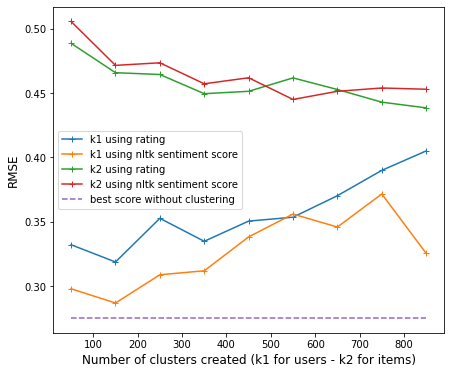

In [47]:
k = range(50, 900, 100)
plt.figure(figsize=(7, 6))
plt.plot(k, rmse_user_overall, marker = '+', label='k1 using rating')
plt.plot(k, rmse_user_nltk, marker = '+', label='k1 using nltk sentiment score')
plt.plot(k, rmse_item_overall, marker = '+', label='k2 using rating')
plt.plot(k, rmse_item_nltk, marker = '+', label='k2 using nltk sentiment score')
plt.plot(k, [0.2753] * len(k), '--', label='best score without clustering')
plt.xlabel('Number of clusters created (k1 for users - k2 for items)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()

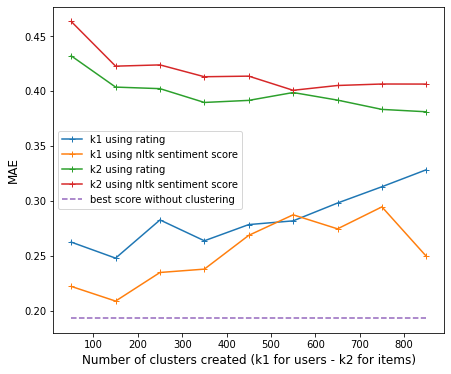

In [48]:
k = range(50, 900, 100)
plt.figure(figsize=(7, 6))
plt.plot(k, mae_user_overall, marker = '+', label='k1 using rating')
plt.plot(k, mae_user_nltk, marker = '+', label='k1 using nltk sentiment score')
plt.plot(k, mae_item_overall, marker = '+', label='k2 using rating')
plt.plot(k, mae_item_nltk, marker = '+', label='k2 using nltk sentiment score')
plt.plot(k, [0.1932] * len(k), '--', label='best score without clustering')
plt.xlabel('Number of clusters created (k1 for users - k2 for items)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend()